# I. Quantum Simulation of the XXX Heisenberg Spin Model with Jakarta

__IBM Quantum - The Open Science Prize 2021__


Urbano L França

## I.1 Introduction





## I.2 Objective of The Open Science Prize

From [The Open Science 2021 description](https://github.com/qiskit-community/open-science-prize-2021):


> One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation.
>
> The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum [spin-1/2](https://en.wikipedia.org/wiki/Spin-1/2) particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, [certain optimization problems can be mapped](https://arxiv.org/pdf/1712.05771.pdf) to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.
>
> There are many different spin models, but we will focus on the [$XXX$ Heisenberg spin model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#XXX_model). Though it is not as well known as the [transverse-field Ising model](https://en.wikipedia.org/wiki/Transverse-field_Ising_model), the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.
>
>[...]
>
>You are to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$ as defined in Section 1. This will be done on the ibmq_jakarta quantum computer. From left to right, the qubits in $|110\rangle$ correspond to ibmq_jakarta's qubits 5, 3, and 1. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$). You will be judged on the clarity, originiality, and creativity of your solution, as well as the fidelity of the evolved state at time $t=\pi$ using [state tomography](https://qiskit.org/documentation/tutorials/noise/8_tomography.html). State tomography is a way of determining the exact quantum state--even phase information--at the end of a quantum circuit by running the circuit multiple times and measuring in different bases. The closer your final quantum state to the expected state, the higher the fidelity. Ibmq_jakarta's qubits 0, 2, 4, and 6 will not be evaluated by the state tomography calculation, so you may use them as you wish. You do not need to follow the same decomposition given in the example above, but your solution must be a Trotterization of $U_{\text{heis3}}(t)$ with at least 4 steps ($n\geq4$). You may find it useful to implement techniques that reduce errors and improve qubit coherence.


## I.3 Approach


* Describe here, including refs to Stenger+, Earnest +, etc

* why $R_{ZX}$ gates -> CNOT already using this calibration

* comment on balance of number of Trotter steps approx and the errors of each gate

* CR pulses

======

We will use pulse efficient implementation of gates with measurement error mitigation...

and the best results of each simulation are executed in the actual Jakarta device

incrementally implement tools to improve the results of the simulation to attempt to achieve  
Our final  apply the methodology of Earnest et al. [[1]](https://arxiv.org/abs/2105.01063) to implement This notebook is organized as follows:

===========

This notebook is organized as follows: in Section [II](II.-The-XXX-Heisenberg-Spin-Model) we describe the XXX Heisenberg spin model, the decomposition of the Hamiltonian operator into quantum gates using the Suzuki-Trotterization decomposition. This discussion follows closely the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021) provided by the organizers of the Open Science Prize 2021. Sec. [III](#III.-Qiskit) imports the packages and backends which will be used in the notebook and contains some functions that will be used in the simulations and device executions. 

In the subsequent two sections, we use several approaches to simulate the Heisenberg model and compare their results. These tests are run on a Jakarta simulator, `FakeJakarta` and are executed using between 4 and 13 Trotter steps to evaluate their performance with increasing Trotterization. In Sec. [IV](#IV.-Standard-Gates) we use the standard implementation of gates in Qiskit to run 4 different sets of experiments that will provide the baseline to compare the pulse efficient solutions. We perform a noiseless test, a non-optimized quantum circuit execution, an optimized quantum circuit execution, and an optimized quantum circuit execution followed by measurement error mitigation using the Qiskit implementation of measurement calibration. In Sec. [V](#V.-Gates-Using-Pulse-Efficient-Template-Optimization) we discuss pulse efficient template optimization and implement this approach to generate pulse efficient versions of the $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gates. After comparing these gates with their standard, CNOT-implemented counterparts, we demonstrate their performance with and without post-processing of the results by applying measurement error mitigation. Finally, with the result of these experiments, in Sec. [VI](#VI.-Jakarta-Runs) we execute the circuits with higher performance on `ibmq_jakarta` and report their final results on the actual device. 



# II. The XXX Heisenberg Spin Model

In this section we brief summarize the description of the XXX Heisenberg spin model deliineated in the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021) for the Open Science Prize 2021.

The Heisenberg model is described by the Hamiltonian operator,

$$
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
$$

where $N$ is the total number of spin 1/2 particles in the model, $J$ is the interaction strength, $\langle ij \rangle$ denotes a sum running over the nearest neighbors, and $\sigma_x$, $\sigma_y$, and $\sigma_z$ are [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices). In the particular case of this challenge, we will work with $N=3$ and  $J=1$, corresponding to the Hamiltonian,

$$
H_{\text{Heis3}} = 
\sum_{\langle ij \rangle}^{3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) .
$$

Since this Hamiltonian is time independent, we can write the solution to the [Schrödinger equation](https://en.wikipedia.org/wiki/Schrödinger_equation) as 

$$
|\psi(t)\rangle = e^{-it H_\text{Heis3}}|\psi(t=0)\rangle  = U_{\text{Heis3}}(t)|\psi(t=0)\rangle , 
$$

where we use natural units ($\hbar = 1$) and the unitary operator is given by

$$
U_{\text{Heis3}}(t) 
= \exp\left[-it \sum_{\langle ij \rangle}^{3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) \right] .
$$

Using the standard representation where the sum starts with the index $0$ instead of $1$, this Hamiltonian can be explicitly written as

$$
\begin{align}
U_{\text{Heis3}}(t) & = \exp\left[-it H_\text{Heis3}\right] \\
& =  \exp\left[-it \left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) \right] \\
& \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] , 
\end{align}
$$

where the local Hamiltonians $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)} $ now act on a Hilbert space of dimension 2. We can use the Suzuki-Trotter decomposition to evolve the system locally over small, discrete time steps $n$ and approximate the operator sum by a product of exponentials,  

$$
\begin{align}
U_{\text{Heis3}}(t) & \approx \left[
\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) 
\exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}}\right)
\right]^n 
+ O\left( \dfrac{t^2}{n}\right) .
\end{align}
$$

The higher-order term is present because the Paulis do not commute [[2,3,4]](#VII.-References), but can be made small for sufficiently large $n$. For this reason, in what follows, we will use only the first-order term on $t$ in this equation. 

In principle, the approximation becomes more accurate as $n$ increases. In practice, however, adding extra steps to the Trotter approximation will also increase the circuit size and time of execution, potentially leading to the accumulation of gate errors and making decoherence more likely.  For this reason, when estimating the fidelities, we expect to observe a trade-off between the validity of approximation provided the Trotter decomposition for low $n$ and circuit size for high $n$. 
 
The equation above can be explicitly written as

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}\right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)\right)\right]^{n} \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n} \ ,
\end{align}
$$

where in the last step the Hamiltonians were once again decomposed because within each 2 spin subsystem the Pauli operator pairs $\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$ commute.

Finally, we can use a more common notation to rename the products inside the unitary with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$, allowing us to write $U_{\text{Heis3}}(t)$ as

$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n} .
$$

This is the final form ot the Trotterized $U_{\text{Heis3}}(t)$ we will implement in the following sections.

# III. Qiskit

## III.1 Libraries and Backends

First, let's import some of the libraries we will be using in this notebook.

In [387]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
#plt.rcParams.update({'font.size': 16})

# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, schedule, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import array_to_latex

# Import qubit states Zero (|0>) and One (|1>) and Pauli operators X, Y, Z, and I
from qiskit.opflow import Zero, One, I, X, Y, Z

from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.test.mock import FakeJakarta

## Import Pulse modules
# The PassManager helps decide how a circuit should be optimized
# (https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)
from qiskit.transpiler import PassManager

# This function will pull pulse-level calibration values to 
# build RZX gates and tell the PassManager to leave RZX gates alone
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho


# Supress warnings
import warnings
warnings.filterwarnings('ignore')

We will also import the Backends we will use in the different sections. While the final runs (Sec. [V](#V.-Jakarta-Runs)) are on the Jakarta backend, most tests and simulations are run on `FakeJakarta()`, chosen because of its capability to run Qiskit Pulse jobs. The baseline noiseless simulation is execute on `QasmSimulator()` and a `QasmSimulator()` of the Jakarta backend is used in simulations of measurement error mitigation.

In [389]:
## load IBMQ account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

# Noiseless simulated backend
sim = QasmSimulator()

ibmqfactory.load_account:WARNING:2022-04-21 12:02:20,769: Credentials are already in use. The existing account in the session will be replaced.


Below we load `ibmq_jakarta` for the actual final runs and test for its Pulse support.

In [390]:
hub = 'ibm-q-community' 
group = 'ibmquantumawards'
project = 'open-science-22'
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_jakarta')
jakarta_backend = provider.get_backend('ibmq_jakarta')

try:
    # Check if backend supports Pulse
    backend_config = jakarta_backend.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")

Backend supports Pulse


Similarly for `sim_noisy_jakarta`:

In [6]:
#Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

try:
    # Check if backend supports Pulse
    backend_config = sim_noisy_jakarta.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")

Backend does not support Pulse


As mentioned before, because `sim_noisy_jakarta` does not support Pulse, we will use `FakeJakarta` for tests of pulse efficient gates.

In [391]:
fake_jakarta_backend = FakeJakarta()

try:
    # Check if backend supports Pulse
    backend_config = fake_jakarta_backend.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")


Backend supports Pulse


## III.2 Auxiliary functions and definitions

To simplify the notebook, we can define a few auxiliary functions which will be used a number of repeated times in the experiments below. These functions implement the state tomography used in the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021), execute Trotter jobs for a predefined number of steps using the different approaches of each section, plot the comparisons between different Trotter runs and experiments, and eliminate idle wires in certain circuits.

But first, we can select the minimum and maximum number of Trotter steps we aim to investigate in our experiments. As mentioned in the [Introduction](#I.1-Introduction), we will calculate 10 different number of steps for each simulation, from $n = 4$ and $n=13$.

In [8]:
n_min_trotter = 4
n_max_trotter = 13

The goal of the challenge is to simulate the time evolution of the XXX Heisenberg spin model with interactions between qubits 1, 3, and 5 with an initial state $|110\rangle$. The function below, based on the original code provided for the prize, implements the state tomography used to compare the [state tomography quantum circuits](https://qiskit.org/documentation/stubs/qiskit.ignis.verification.state_tomography_circuits.html) with the results of these circuits using Qiskit's [`StateTomographyFitter`](https://qiskit.org/documentation/stubs/qiskit.ignis.verification.StateTomographyFitter.html).

In [9]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    '''
    Performs the state tomography between a job result and a state tomography circuit. 
    Returns the state fidelity between the state tomography fitter and the target state defined 
    inside the function (One^One^Zero for the challenge).
    
    Usage: state_tomo(result, st_qcs)
    
    result: instance of job.result()
    st_qcs: instance of qiskit.ignis.verification.state_tomography_circuits
    
    Returns: fidelity
    '''
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

We will run a 

In [10]:
run_and_evaluate_with_steps_opt = np.nan
run_and_evaluate_with_steps_pe = np.nan
run_and_evaluate_with_steps_pe = np.nan
run_and_evaluate_with_steps_pe_mem = np.nan

def execute_Trotter_jobs(function, backend, title, 
                         n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter):
    '''
    Run the function with Trotter jobs
    
    Returns: list with mean fidelities for each Trotter step
    '''
    list_avgs = []
    list_avgs_mitigated = []
    
        # Functions without Error Mitigation 
    if function in [run_and_evaluate_with_steps,
                    run_and_evaluate_with_steps_opt]:

        for j in range(n_min_trotter, n_max_trotter+1,1):

            print('='*80)
            print('\n Steps={:.0f} \n'.format(j))
            print('\n'+title)
        
            avg = function(j, backend)
            list_avgs.append(avg)
            
        return list_avgs
            
    else: # Functions with error mitigation returns both unmitigated and mitigated results
        for j in range(n_min_trotter, n_max_trotter+1,1):

            print('='*80)
            print('\n Steps={:.0f} \n'.format(j))
            print('\n'+title)

            avg_unmitigated, avg_mitigated = function(j, backend)
            list_avgs.append(avg_unmitigated)
            list_avgs_mitigated.append(avg_mitigated)

        return list_avgs, list_avgs_mitigated

Plotting function for the comparison of different steps and approaches.

In [11]:
def trott2angle(n):
    '''
    Angle function for secondary axis on Trotter plot
    '''
    x = 180/n
    return x

def plot_comparisons_trotter(list_of_test_avgs, n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter):
    '''
    Plots a comparison between n_nim_trotter and n_max_trotter of the different simulations on list_of_test_avgs
    '''

    list_colors=['darkgrey','deepskyblue', 'blue', 'darkblue', 'red', 'firebrick']
    list_markers =['*','P', '^', 'v', 's', 'o']
    list_labels = ['Noiseless (QasmSimulator)',
                   'Basis Gates', 
                   'Basis Gates Opt 3', 
                   'Basis Opt 3 and MEM', 
                   'PE Template Optimization', 
                   'PE Template Optimization and MEM']

    import seaborn as sns
    sns.set(style='ticks', context='notebook')
    fig,ax = plt.subplots(figsize=(8,8))

    i=0
    for list_avgs in list_of_test_avgs:
        plt.plot(np.linspace(n_min_trotter,n_max_trotter,n_max_trotter+1 - n_min_trotter), 
                 list_avgs, 
                 alpha=0.85,
                 linestyle='--',
                 linewidth = 0.7,
                 color=list_colors[i],  
                 marker=list_markers[i], 
                 markersize=7,
                 label=list_labels[i])
        i+=1

    plt.legend(loc='best', bbox_to_anchor=(0.42, 0., 0.0, 1.0))
    plt.xlabel('Trotter steps (N)')
    plt.ylabel('State tomography fidelity (FakeJakarta)')
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
    ax.set_ylim(ymin=0)

    inverse = trott2angle ## plot secondary axis on top with corresponding angle
    secax = ax.secondary_xaxis('top', functions=(trott2angle,inverse))
    #secax.xaxis.set_minor_locator(AutoMinorLocator())
    secax.set_xlabel('angle [degrees]')
    
    return

In [12]:
## Remove idle wires to create a 2-qubit gate
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

# IV. Standard Gates

## Basic Qiskit

In this section, we will use the decomposition of $U_{\text{Heis3}} (t)$ defined in the Open Science Prize main notebook. The function below returns the parameterized Trotter gate using 2-qubit basis gates.

In [13]:
def return_standard_Trott(t):

    ########################
    ###### Gates
    ########################

#     # Parameterize variable t to be evaluated at t=pi later
#     t = Parameter('t')

    # Build a subcircuit for XX(t) two-qubit gate
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()

    # Build a subcircuit for YY(t) two-qubit gate
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()

    # Build a subcircuit for ZZ(t) two-qubit gate
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)

    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()

    ########################
    ###### Circuit for a single Trotter step
    ########################
    
    # Combine subcircuits into a single multiqubit gate representing a single trotter step
    num_qubits = 3

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    for i in range(0, num_qubits - 1):
        Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

    #display(Trot_qc.draw())
    # Convert custom quantum circuit into a gate
    Trot_gate = Trot_qc.to_instruction()

    return Trot_gate
        
    

We can also define a function that will create the 7-qubit quantum circuit, append the Trotter gate a number of times equal to `trotter_steps`, generate the state tomography circuits, execute them, and return the fidelities using the state_tomo function just defined above. This function will return the mean fidelity of 8 job runsas defined in the original Open Science Prize notebook. This function calculates the circuit and fidelities as outlined in the [original notebook](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-challenge.ipynb).


In [225]:
trotter_steps = 4
backend = fake_jakarta_backend
########################
###### Time Evolution
########################

# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
#trotter_steps = 8  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
#st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
#st_qcs[-1].draw()  # only view trotter gates

########################
###### Execution
########################

shots = 8192
reps = 8

job = execute(st_qcs, backend, shots=shots)

In [235]:
import qiskit
raw_results = {'0x1': 8192}
qiskit.result.Counts(raw_results)
#job.result().replace(counts={'0x4': 940, '0x6': 1047, '0x1': 1060, '0x3': 1077, '0x7': 974, '0x0': 1066, '0x2': 1036, '0x5': 992})

{'1': 8192}

In [14]:
def run_and_evaluate_with_steps(trotter_steps, backend):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    #st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

    # Display circuit for confirmation
    # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
    #st_qcs[-1].draw()  # only view trotter gates
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
#        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
        
    #print('='*80)
    #print('\n Steps ={:.0f}'.format(trotter_steps)) 
    if backend != sim:
        print('\n Duration ={:.0f}'.format(schedule(transpile(qc, backend),backend).duration)) 
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    print('='*80)
    
    return(round(np.mean(fids),4))

## Noiseless test using the `QasmSimulator`

First, let's try with noiseless simulator to check what could be achieved.

In [15]:
list_avgs_noiseless = execute_Trotter_jobs(run_and_evaluate_with_steps, backend=sim, 
                                          title='Noiseless')


 Steps=4 


Noiseless
Job ID 7ced18f3-d059-4611-b82c-f53f9f0cf0ce
Job ID 2800dcb1-b28d-40a2-ae41-54b90d255ffa
Job ID 9ae6c948-d517-436d-8d15-2d2cce5e2f33
Job ID a6905811-6807-465f-a4ee-fcce44c51837
Job ID 50c9dbf9-45cd-42d1-bf2d-ce9bf7742d8a
Job ID 61508502-c805-4fc5-9959-928a097ef757
Job ID c5c0a0c1-b1ed-4e78-a751-5fac021df049
Job ID 0c3e386b-d643-46e6-82c0-64addde8b6c7

 state tomography fidelity = 0.0002 ± 0.0002

 Steps=5 


Noiseless
Job ID 1defc08f-0f06-441e-a625-76d61f9a25b5
Job ID 9c9fcb9e-5b7f-41a7-8672-7a8afda6508d
Job ID 256bf205-06c1-43e5-a645-1b128492d56c
Job ID af747864-8693-4f83-93d8-a646e7158263
Job ID 01c76952-8785-4b2b-81b5-0c9443016bfe
Job ID da30b488-c449-4adf-a87b-59c55daa0dbe
Job ID e862a17e-fb68-4fc9-9a94-ddda7458e0b9
Job ID 0f28c1ee-2f44-4816-a374-c2cab1e44b0e

 state tomography fidelity = 0.2572 ± 0.0015


In [16]:
#list_avgs_noiseless

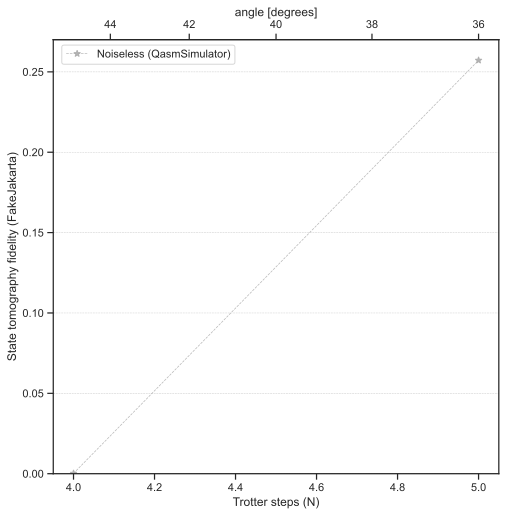

In [17]:
plot_comparisons_trotter([list_avgs_noiseless])

## Jakarta simulator

Now with FakeJakarta

In [18]:
list_avgs_standard = execute_Trotter_jobs(run_and_evaluate_with_steps, backend=fake_jakarta_backend, 
                                          title='Standard Basis Gates')


 Steps=4 


Standard Basis Gates
Job ID f2800339-b47a-48ad-b08c-1f67c5d415c2
Job ID 9541b3fb-ad52-466c-bdd6-35f08ed81c3f
Job ID 60c3b4e1-d757-440f-9308-5000dcef5c38
Job ID 219c0c1d-3499-47ef-9cbe-9d88348fca40
Job ID 302132ad-b4f4-4634-991c-62e5fa5327ce
Job ID 7e112a5f-ce42-43d3-907e-97d94ee64a1a
Job ID afe157ec-385f-486e-86a2-9cbf7f5a047a
Job ID 54149f5a-ddda-4b8a-bc3a-31c9469567c9

 Duration =82336

 state tomography fidelity = 0.0584 ± 0.0013

 Steps=5 


Standard Basis Gates
Job ID ca97429c-5668-465c-bcf6-2fb4b773fad1
Job ID ff54c2e8-7fdf-4119-8b3b-44752b0342ea
Job ID db460e0a-d07a-4a32-91b7-55962f792b97
Job ID e1d16a68-452b-490f-8858-159163c3c725
Job ID 1e297ce6-3923-4287-82b2-4da6c9878dfa
Job ID afe1e6ea-3f9e-4469-987b-bd51b70a7ce0
Job ID 0d532df5-7992-4984-9f70-5e8bbcad0d13
Job ID 44595070-ddd7-4545-9940-da60f92c0afb

 Duration =102880

 state tomography fidelity = 0.1431 ± 0.0019


First, we will define a function to plot these comparisons that we will use across the notebook.

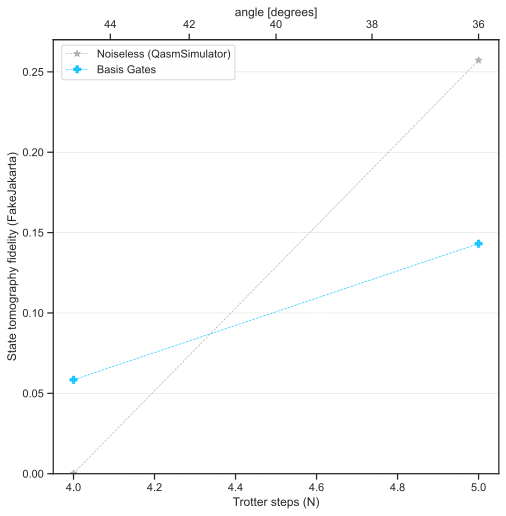

In [19]:
plot_comparisons_trotter([list_avgs_noiseless, list_avgs_standard])

Using the basis gates as defined in the standard qiskit library, we see that we achieve maximum state fidelities of the order 0.2. Notice that this figure does show a trade-off between a large number of gates (which increases the precision of the Trotter approximation) and the duration of the circuits (which increases the likelihood of decoherence).

## Standard Gates - Optimization Level 3

To improve on the results above, we can optimize the transpilation of the circuits using the qiskit parameter `optimization_level` when transpiling the circuits. 

In [101]:
def run_and_evaluate_with_steps_opt(trotter_steps, backend):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

    # Display circuit for confirmation
    # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
    #st_qcs[-1].draw()  # only view trotter gates
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
#        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
        
    #print('='*80)
    #print('\n Steps ={:.0f}'.format(trotter_steps)) 
    print('\n Duration ={:.0f}'.format(schedule(transpile(qc, backend),backend).duration)) 
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    print('='*80)
    
    return(round(np.mean(fids),4))

In [102]:
#run_and_evaluate_with_steps_opt(4, backend=fake_jakarta_backend)

In [21]:
list_avgs_standard_opt = execute_Trotter_jobs(run_and_evaluate_with_steps_opt, backend=fake_jakarta_backend, 
                                          title='Standard Basis Gates - Optimization Level 3')


 Steps=4 


Standard Basis Gates - Optimization Level 3
Job ID f3c85eaa-2ac3-4f1b-a1a4-e9af269d34b8
Job ID a1fdd0d5-2b4e-4815-82c1-32bc14e84bce
Job ID 590aa9ea-db79-444b-937e-580571d1fe2d
Job ID de32ba4b-9580-40f3-8509-6d7bf086b5d9
Job ID 33a4272a-a02f-491b-9501-88c634a29f0d
Job ID 5df11c05-3685-4452-a03a-59f9907f8cdd
Job ID e618908b-c567-44f0-90e8-caf09a02240a
Job ID fc38d962-6788-4503-9121-991e20a9e043

 Duration =82336

 state tomography fidelity = 0.0390 ± 0.0012

 Steps=5 


Standard Basis Gates - Optimization Level 3
Job ID ca34eda3-a37e-4334-867a-1719e9796f0e
Job ID c5777d6b-525f-4f23-b2a2-b88b0b1debbd
Job ID 1263dc1c-025c-452b-a434-2a7dbf951391
Job ID b40cbab2-2233-4674-a3bc-25611c0d31cc
Job ID c41a3f7d-999f-46d3-be52-25ba6057b72e
Job ID 9c70c7d4-afc5-436e-9f20-252c8c47d1c3
Job ID c39dfbb1-e058-4d29-9c5b-4bc078925886
Job ID 84d69dda-55b0-4916-b65a-95dfe3ff2323

 Duration =102880

 state tomography fidelity = 0.2036 ± 0.0008


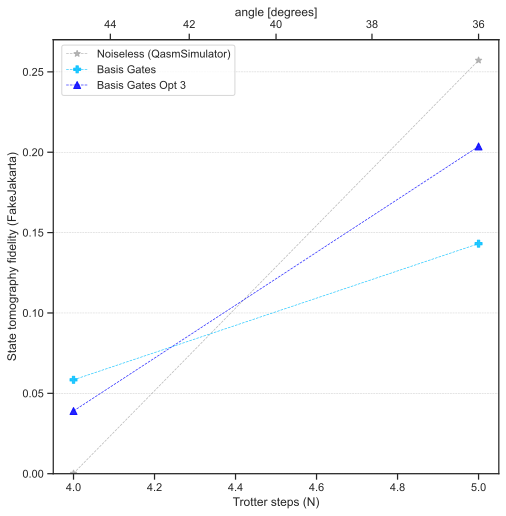

In [22]:
plot_comparisons_trotter([list_avgs_noiseless, list_avgs_standard, list_avgs_standard_opt])

## Standard Gates - Optimization Level 3 with Measurement Error Mitigation

Describe here measurement error mitigation

In [23]:
from qiskit import Aer
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
#from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
# Noise model
from qiskit.providers.aer.noise import NoiseModel
# from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from itertools import combinations
from qiskit.compiler import assemble

We will define two measurement filters below. The first one, `calculate_meas_filter_noise_from_backend(backend)` utilizes the simulator `sim_noisy_jakarta` with a NoiseModel obtained from the Jakarta backend, while the second (`calculate_meas_filter`)  was obtained directly from a run on the Jakarta backend. 

In [24]:
def calculate_meas_filter_noise_from_backend(backend = sim_noisy_jakarta):
    '''
    
    Measurement error mitigation strategy based on a simple Pauli error model 
    assigning a probability p of an X bit flip defined on function `get_noise()`. 
    
    Returns measurement filter to mitigate measurement errors applied to job results.
    
    
    '''
    qr = QuantumRegister(3)
    meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
    
    ###################################
    ## Noise model from Jakarta Backend
    ##################################
    noise_model = NoiseModel().from_backend(jakarta_backend)
    
    t_qc = transpile(meas_calibs, backend, basis_gates=noise_model.basis_gates, 
                     coupling_map=backend.configuration().coupling_map)
    qobj = assemble(t_qc, shots=10000)
    cal_results = backend.run(qobj, noise_model=noise_model,shots=10000).result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    print('Backend Noise + Sim')
    #display(array_to_latex(meas_fitter.cal_matrix))
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    

    return meas_filter

In [25]:
def calculate_meas_filter(backend=jakarta_backend, running_on_device = False, job_id = '625647d29def42732fa98d01'):
    '''
    
    Measurement error mitigation strategy based on a simple Pauli error model 
    assigning a probability p of an X bit flip defined on function `get_noise()`. 
    
    Returns measurement filter to mitigate measurement errors applied to job results.
    
    
    '''
    qr = QuantumRegister(3)
    meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

    ## used to run on device. Once it is run, just pull the results from the jobs 
    if running_on_device == True:
        # Execute the calibration circuits without noise
        t_qc = transpile(meas_calibs, backend)
        qobj = assemble(t_qc, shots=10000)
        cal_results = backend.run(qobj, shots=10000).result()
    else:
#        job_id = '625647d29def42732fa98d01' # Default is calibration from jakarta
        cal_results = backend.retrieve_job(job_id).result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    # Get the filter object
    meas_filter = meas_fitter.filter

    return meas_filter

In [26]:
### Applying filter for measurement error mitigation
meas_filter = calculate_meas_filter(jakarta_backend)
#meas_filter = calculate_meas_filter_noise_from_backend(sim_noisy_jakarta)

We can add this to our previous function:

In [103]:
def run_and_evaluate_with_steps_opt_mem(trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)
#    st_qcs = transpile(st_qcs, backend=backend, optimization_level=1)

    # Display circuit for confirmation
    # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
    #st_qcs[-1].draw()  # only view trotter gates
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 1
    
    jobs = []
    jobs_mitigated =[]
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        
        ## PASS THIS TO NEXT for LOOP
        ### UF Results with mitigation - 
        job_mitigated_results = meas_filter.apply(job.result())
        jobs_mitigated.append(job_mitigated_results)
        
        jobs.append(job)
        
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
    #         print(job.result())
    #    job_mitigated_results = meas_filter.apply(job.result())
    #    fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_unmitigated.append(fid)
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        job_mitigated_results = meas_filter.apply(job.result())
        print(job_mitigated_results)
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(qc, backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)
        
#     # Compute tomography fidelities for each repetition
#     fids = []
#     for job_m_results in jobs_mitigated:
#         fid = state_tomo(job_m_results, st_qcs) ## UF
#         fids.append(fid)
        
#     print('\n Duration ={:.0f}'.format(schedule(transpile(qc, backend),backend).duration)) 
#     print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
#     print('='*80)
    
#     return(round(np.mean(fids),4))

In [104]:
run_and_evaluate_with_steps_opt_mem(1, fake_jakarta_backend)

Job ID f8df72d4-1bb4-4703-b0d1-556051487d96
Result(backend_name='qasm_simulator', backend_version='0.10.4', qobj_id='3dd263d5-aa26-4644-b380-51ade6a4c2f7', job_id='f8df72d4-1bb4-4703-b0d1-556051487d96', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'000': 939.8747437223316, '001': 1007.9251481247574, '010': 994.3549665633719, '011': 1092.6384733760933, '100': 933.4613189847815, '101': 1027.0546724855326, '110': 1050.0921810033308, '111': 1146.5984957398016}), header=QobjExperimentHeader(clbit_labels=[['c31', 0], ['c31', 1], ['c31', 2]], creg_sizes=[['c31', 3]], global_phase=2.3561944901923457, memory_slots=3, metadata={}, n_qubits=7, name="('X', 'X', 'X')", qreg_sizes=[['q', 7]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6]]), status=DONE, seed_simulator=1258687801, metadata={'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': True, 'parallel_state_update': 

(0.9161, 0.9946)

In [28]:
list_avgs_standard_opt, list_avgs_standard_opt_mem = execute_Trotter_jobs(run_and_evaluate_with_steps_opt_mem, 
                                                  backend=fake_jakarta_backend, 
                                                  title='Standard Basis Gates - Optimization Level 3 - MEM')


 Steps=4 


Standard Basis Gates - Optimization Level 3 - MEM
Job ID 5fcd34bd-9223-48c8-a041-3113ef8ebf12
Job ID 70f19e37-a361-4ec7-8853-5c7dccb4639d
Job ID 634296c7-1df5-4751-a514-123ff9afae1c
Job ID 05a2fd34-f2f2-43ee-8fb9-9467173fa3c6
Job ID 1ae30f04-74fc-4795-873f-e092112b2065
Job ID 0e691112-44b1-4220-853d-f0cab0b905cd
Job ID 97b77faa-e181-43c6-8de3-dbbcd43492f0
Job ID bcecdc7a-76f6-401f-945a-ba0d08837d08

 Duration =82336

 Unmitigated state tomography fidelity = 0.0405 ± 0.0013

 Mitigated state tomography fidelity = 0.0320 ± 0.0014

 Steps=5 


Standard Basis Gates - Optimization Level 3 - MEM
Job ID 23781a1c-86b5-482f-9519-9fcb64187741
Job ID 35c4a1a0-a7fd-4ad7-bc7a-42f9fea3eec8
Job ID aa51c83a-65f9-40cd-8eec-6c817586509f
Job ID da78543f-2dd2-4b42-9d98-d50130efc5fb
Job ID 1ce4f691-a82e-46ab-a596-a876099b6b12
Job ID 1209f8c9-503f-4191-8723-db8263ae83a3
Job ID 5500a603-de55-4d11-9a82-f18d840147fc
Job ID 7a2f2375-df1e-4a40-ad60-80a43fae8720

 Duration =102880

 Unmitigated state

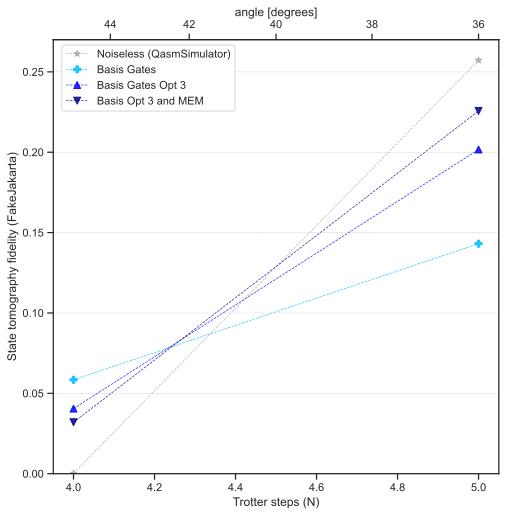

In [29]:
plot_comparisons_trotter([list_avgs_noiseless,
                          list_avgs_standard, 
                          list_avgs_standard_opt,
                          list_avgs_standard_opt_mem])

## ZNE

In [30]:
import pandas as pd
from qiskit.result import models
from qiskit.result import Result

def transform_zne_results(job):
    '''
    Reads a job, uses zne on all statevectors, and transforms the output of mitiq 
    ZNE into a job.result to be used on state_tomo
    '''
    
    ## Add zeros to statevectors not measure to ensure zne can be calculated. Will use padas dataframe for this 
    df_ = {}
    for i in range(len(scale_factors)):
        df_[i] = pd.DataFrame.from_dict(job.result().get_counts(i), orient='index').reset_index()
        df_[i].columns = ['sv', 'counts_'+str(i)]

    df_final = df_[0]
    for i in range(1, len(scale_factors)):
        df_final = df_final.merge(df_[i], on='sv', how='outer').replace(np.nan,0)
    df_final = df_final.set_index('sv')
    #display(df_final)
    
    all_counts =[]
    all_expectation_values = []
    for i in range(len(folded_circuits)):
        all_counts.append(df_final['counts_'+str(i)].astype(int).to_dict())
        df_final2 = round(df_final.astype(float)/shots, 4)
        all_expectation_values.append(df_final2['counts_'+str(i)].to_dict())

    ## Dictionary of expectation values, including statevectors without counts, to be passed to mitiq
    expectation_values={}
    for sv in sorted(list(df_final.index)):
        expectation_values[sv] = list(df_final2.T[sv])
        #display(expectation_values[sv])
        
    ## Run zne extrapolation for all statevectors
    mitigated_sv_counts = {}
    for sv in sorted(list(df_final.index)):

        print("Unmitigated expectation value:", round(expectation_values[sv][0],3))

        zero_noise_value = zne.ExpFactory.extrapolate(scale_factors, expectation_values[sv], asymptote=0.5)
        print(f"Extrapolated zero-noise value:", round(zero_noise_value,3))
        #zero_noise_value

        ## correcting for negative counts
        if zero_noise_value < 0:
            zero_noise_value = 0
        mitigated_sv_counts[sv] = int(zero_noise_value*shots)

    #display(mitigated_sv_counts)
    
    ## Assign mitigated statevector counts to a job.result()
    ## Based on an example from a testing file on 
    # https://github.com/Qiskit/qiskit-terra/blob/0caab4a3ec1f8ced437be59d1e77657922771392/test/python/result/test_result.py

    raw_counts = mitigated_sv_counts
    no_header_processed_counts = {bin(int(bs[2:], 16))[2:]: counts for
                                  (bs, counts) in raw_counts.items()}
    data = models.ExperimentResultData(counts=raw_counts)
    exp_result = models.ExperimentResult(shots=14, success=True, meas_level=2, data=data)
    result = Result(backend_name='jakarta_backend', backend_version='1.0.0',
                    qobj_id='id-123',job_id='job-123', success=True, results=[exp_result])
    display(result)
    
    return result

In [384]:
def run_and_evaluate_with_steps_zne(trotter_steps, backend, noise_level=0.05):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    #st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

    # Display circuit for confirmation
    # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
    #st_qcs[-1].draw()  # only view trotter gates
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8
    
    scale_factors = [1., 1.5, 2., 2.5, 3.]
    folded_circuits = [ zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors]

    # Check that the circuit depth is (approximately) scaled as expected
    for j, c in enumerate(folded_circuits):
        print(f"Number of gates of folded circuit {j} scaled by: {len(c) / len(circuit):.3f}")
        
    if USE_REAL_HARDWARE:
        # Run the circuit on hardware
        job = qiskit.execute(
            experiments=folded_circuits,
            backend=backend,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots
        )
    else:
        # Simulate the circuit with noise
        noise_model = initialized_depolarizing_noise(noise_level=noise_level)
        job = qiskit.execute(
            experiments=folded_circuits,
            backend=qiskit.Aer.get_backend("qasm_simulator"),
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
        )

    all_results = [job.result() for i in range(len(folded_circuits))]
    #print(f"Expectation values:\n{expectation_values}")
    

    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        print(job.result())
        jobs.append(job)
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        zero_noise_value ={}
        three_qubit_basis = ['000', '001', '010', '011','100','101', '110', '111']
        for sv_basis in three_qubit_basis:
            all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
            expectation_values = [counts.get(sv_basis) / shots for counts in all_counts]
            zero_noise_value[sv_basis] = zne.ExpFactory.extrapolate(scale_factors, expectation_values, asymptote=0.5)

        print(zero_noise_value)
            
#        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(zero_noise_value, st_qcs) ## UF
        fids.append(fid)
        
            #print('='*80)
    #print('\n Steps ={:.0f}'.format(trotter_steps)) 
    if backend != sim:
        print('\n Duration ={:.0f}'.format(schedule(transpile(qc, backend),backend).duration)) 
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    print('='*80)
    
    return(round(np.mean(fids),4))

# V. Gates Using Pulse Efficient Template Optimization


Explain Template Optimization

In [32]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library.standard_gates.equivalence_library import (
    StandardEquivalenceLibrary as std_eqlib,
)
from qiskit.transpiler.passes import (
    TemplateOptimization,
    Collect2qBlocks,
    ConsolidateBlocks,
    UnrollCustomDefinitions,
    BasisTranslator,
    Optimize1qGatesDecomposition,
)
from qiskit.transpiler.passes.calibration.builders import RZXCalibrationBuilderNoEcho
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import (
    EchoRZXWeylDecomposition,
)
from itertools import combinations
from qiskit.compiler import assemble
#from qiskit.assembler import assemble, disassemble
#from qiskit.transpiler.passes.optimization.template_optimization import TemplateOptimization

In [33]:
###########################################
## RZZ gate

def rzz_cnot(t=np.pi):
    
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr)

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)
        
    return ZZ_qc

def rzz_pe(t=np.pi):
    ## ZZ Pulse efficient from Earnest et al., 2021: Fig (1a)
    
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr)
    
    #################### 
    ##### ZZ_pe gate
    ZZ_qc.rz(np.pi/2,1)
    ZZ_qc.sx(1)
    ZZ_qc.rz(np.pi/2,1)
    ### Native pulse RZX from Earnest et al., 2021 Fig (2c), (2d)
    ZZ_qc.rzx(t, 0, 1)
    ZZ_qc.x(0)
    ZZ_qc.rzx(-t, 0, 1)
    ZZ_qc.x(0)
    ###    
    ZZ_qc.rz(np.pi/2,1)
    ZZ_qc.sx(1)
    ZZ_qc.rz(np.pi/2,1)    
    ####################

    return ZZ_qc

###########################################
## RYY gate

def ryy_cnot(t=np.pi):
    
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr)
    
    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cx(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cx(0,1)
    YY_qc.rx(-np.pi/2,[0,1])
    
    return YY_qc


def ryy_pe(t=np.pi):
    
    
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr)

    YY_qc.rx(np.pi/2,[0,1])
    ####################
    ##### ZZ_pe gate: see above
    YY_qc.rz(np.pi/2,1)
    YY_qc.sx(1)
    YY_qc.rz(np.pi/2,1)
    ### Native pulse RZX
    YY_qc.rzx(t, 0, 1)
    YY_qc.x(0)
    YY_qc.rzx(-t, 0, 1)
    YY_qc.x(0)
    ###    
    YY_qc.rz(np.pi/2,1)
    YY_qc.sx(1)
    YY_qc.rz(np.pi/2,1)    
    ####################
    YY_qc.rx(-np.pi/2,[0,1])
    
    return YY_qc


###########################################
## RXX gate

def rxx_cnot(t=np.pi):
    
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr)
    
    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])
    
    return XX_qc


def rxx_pe(t=np.pi):
    
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr)

    XX_qc.ry(np.pi/2,[0,1])
    ####################
    ##### ZZ_pe gate: see above
    XX_qc.rz(np.pi/2,1)
    XX_qc.sx(1)
    XX_qc.rz(np.pi/2,1)
    ### Native pulse RZX
    XX_qc.rzx(t, 0, 1)
    XX_qc.x(0)
    XX_qc.rzx(-t, 0, 1)
    XX_qc.x(0)
    ###    
    XX_qc.rz(np.pi/2,1)
    XX_qc.sx(1)
    XX_qc.rz(np.pi/2,1)    
    ####################
    XX_qc.ry(-np.pi/2,[0,1])
    
    #display(XX_qc)
    
    return XX_qc



In [34]:
#rzz_template(t=np.pi)

__FIND THE SOURCE AND RUN__

In [35]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
Convenience function to load RZXGate based templates.
"""

from enum import Enum
from typing import List, Dict

from qiskit.circuit.library.templates import rzx


class RZXTemplateMap(Enum):
    """Mapping of instruction name to decomposition template."""

    ZZ1 = rzx.rzx_zz1()
    ZZ2 = rzx.rzx_zz2()
    ZZ3 = rzx.rzx_zz3()
    YZ = rzx.rzx_yz()
    XZ = rzx.rzx_xz()
    CY = rzx.rzx_cy()


def rzx_templates(template_list: List[str] = None) -> Dict:
    """Convenience function to get the cost_dict and templates for template matching.
    Args:
        template_list: List of instruction names.
    Returns:
        Decomposition templates and cost values.
    """
    if template_list is None:
        template_list = ["zz1", "zz2", "zz3", "yz", "xz", "cy"]

    templates = list(map(lambda gate: RZXTemplateMap[gate.upper()].value, template_list))
    cost_dict = {"rzx": 0, "cx": 6, "rz": 0, "sx": 1, "p": 12, "h": 1, "rx": 6, "ry": 6}

    rzx_dict = {"template_list": templates, "user_cost_dict": cost_dict}

    return rzx_dict

## Compare standard gates with pulse efficient gates

In [36]:
tt = 3*np.pi/11

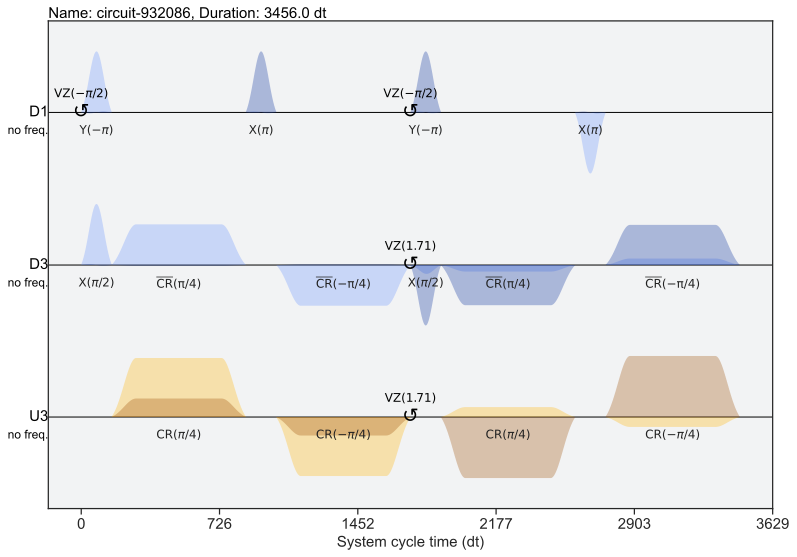

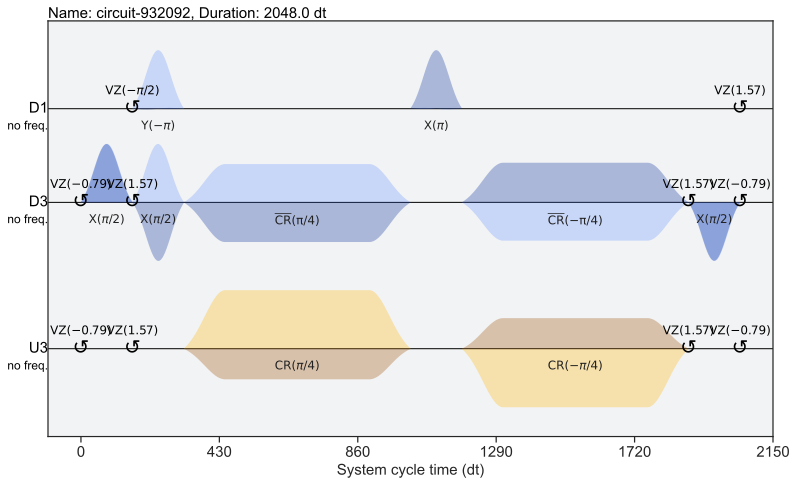

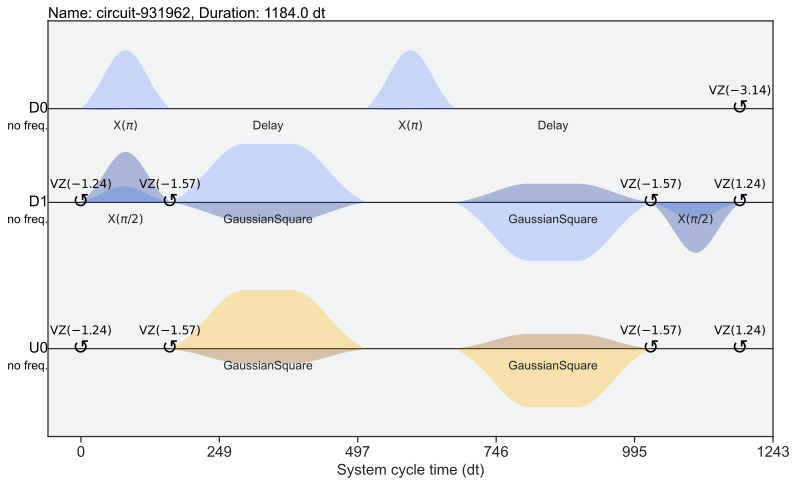

In [37]:
rzx_basis = ["rzx", "rz", "sx", "x"]
pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis),

    ]
)


pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rzz_pe(t=tt).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx.draw()
qc_pe = pulse_efficient.run(qc_rzx)

display(schedule(transpile(rzz_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(transpile(rzz_pe(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

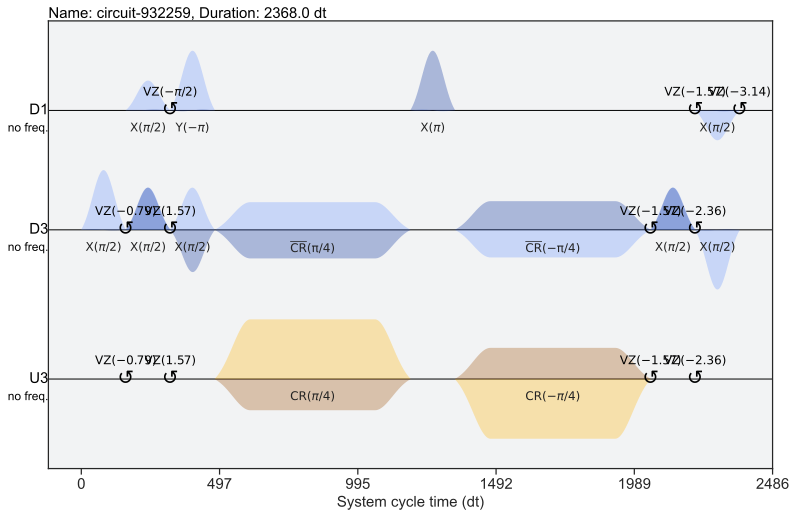

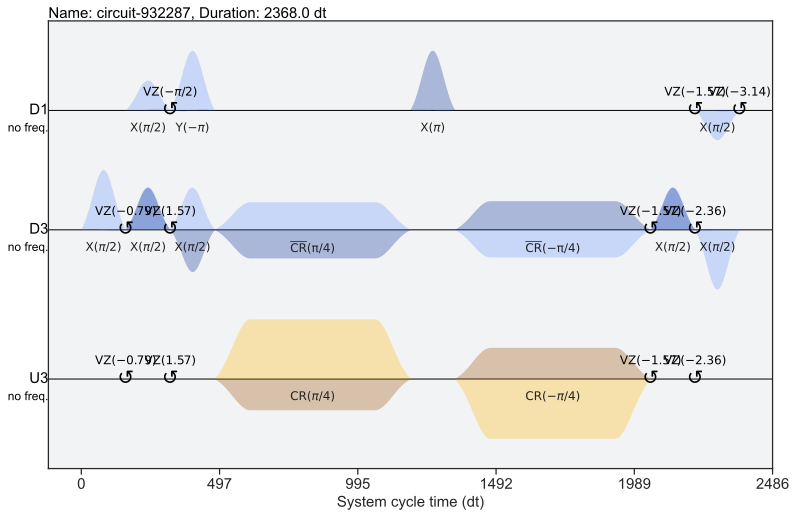

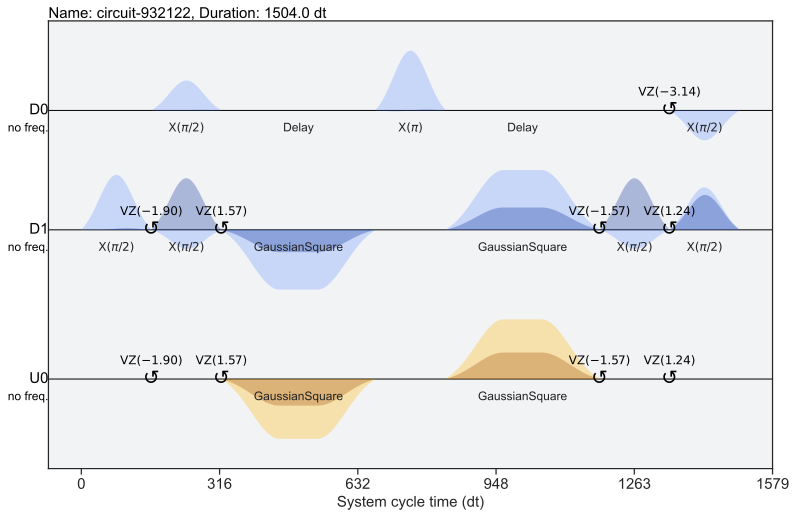

In [38]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(ryy_pe(t=tt).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx.draw()
qc_pe = pulse_efficient.run(qc_rzx)
display(schedule(transpile(ryy_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(transpile(ryy_pe(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

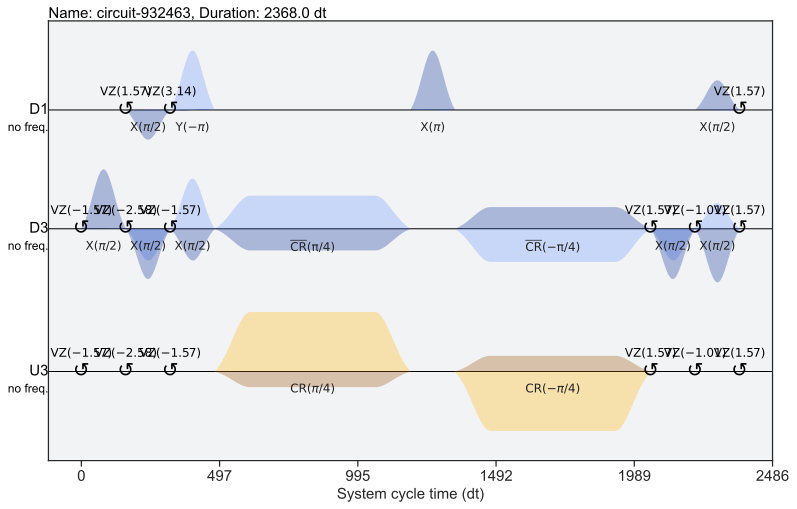

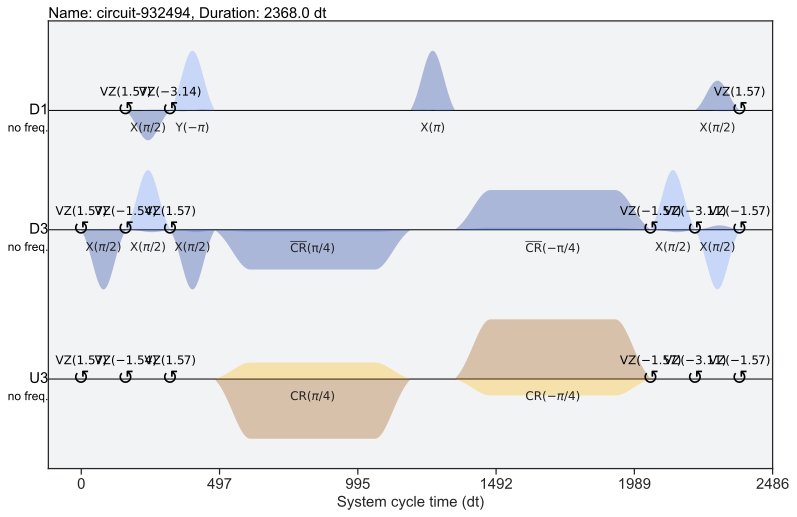

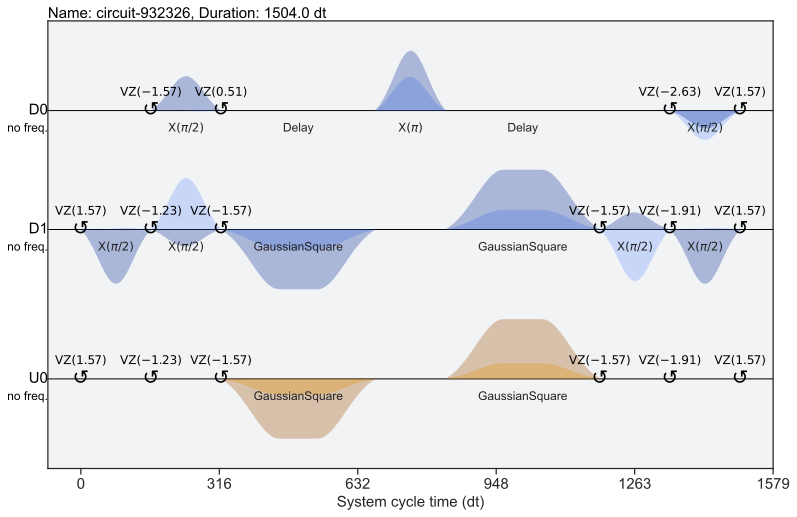

In [39]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rxx_pe(t=tt).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx.draw()
qc_pe = pulse_efficient.run(qc_rzx)
display(schedule(transpile(rxx_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(transpile(rxx_pe(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

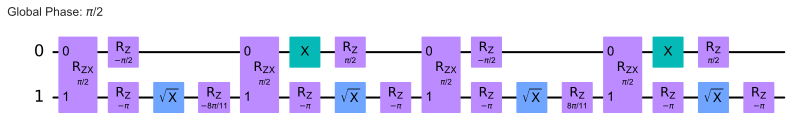

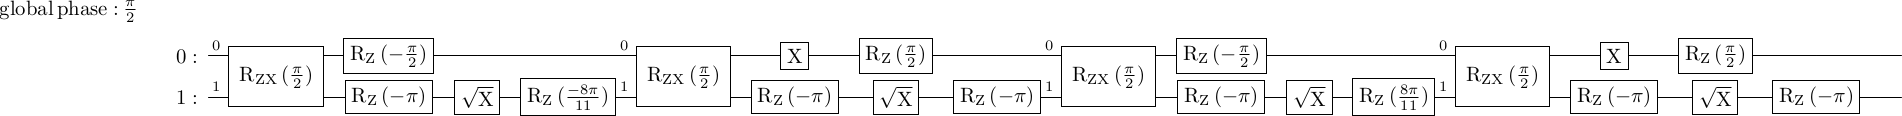

In [40]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rzz_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())
qc_rzx.draw('latex')

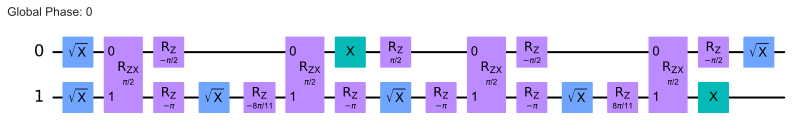

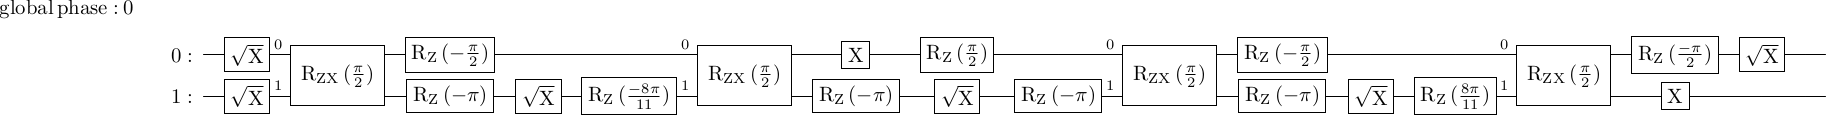

In [41]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(ryy_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())
qc_rzx.draw('latex')

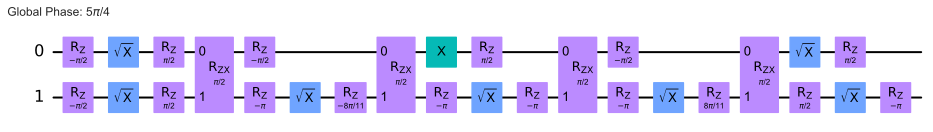

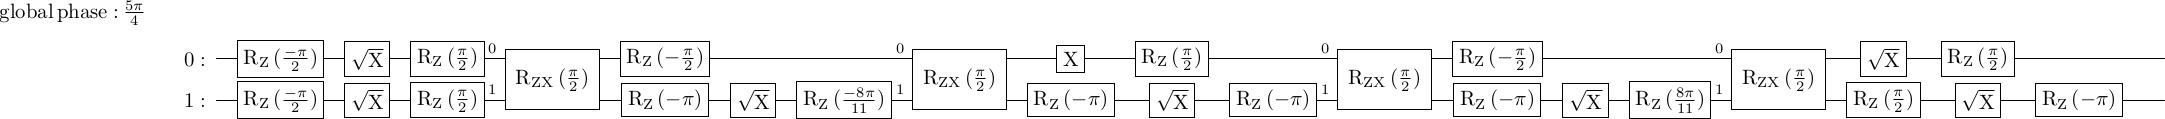

In [42]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rxx_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())
qc_rzx.draw('latex')

### Finding pulse efficient gates

In [43]:
def find_pulse_efficient_gate(gate = rzz_cnot):
    '''
    Usage: find_pulse_efficient_gates(t=np.pi, template_list=[rzz_template(t=t)], gate = rzz(t=t))
    
    '''
        
    rzx_basis = ["rzx", "rz", "sx", "x",'cx']
    pulse_efficient = PassManager([
            # Consolidate consecutive two-qubit operations.
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates = rzx_basis),
            # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
            EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
            # Attach scaled CR pulse schedules to the RZX gates.
            RZXCalibrationBuilderNoEcho(backend),
            ## Simplify single-qubit gates.
            UnrollCustomDefinitions(std_eqlib, rzx_basis),
            BasisTranslator(std_eqlib, rzx_basis),
            Optimize1qGatesDecomposition(rzx_basis),
        
        ]
    )

#     # Template Optimization - see Earnest+ 
#     pass_ = TemplateOptimization(template_list=template_list, 
#                                  user_cost_dict= cost_dict)

    # Template Optimization - see Earnest+ 
    pass_ = TemplateOptimization(**rzx_templates())

    
    qc_TO = PassManager(pass_).run(gate.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    qc_rzx = transpile(qc_TO,
                       backend,
                       optimization_level=1,
                       basis_gates = gates)
    
    
    qc_pe = pulse_efficient.run(qc_rzx)

    if t%np.pi==0:
        qc_pe.i([0,1])
        qc_pe = remove_idle_qwires(qc_pe)

    else:
        qc_pe = remove_idle_qwires(qc_pe)
    
    return qc_pe#two_q_gate

In [44]:
# def return_Trott_pe(t):

# #     ########################
# #     ###### Gates
# #     ########################

# #     qc_ZZ = find_pulse_efficient_gate(gate=rzz_pe(t=t))
# #     #display(qc_ZZ.draw('latex'))
# #     qr_ZZ = QuantumRegister(2)
# #     ZZ = QuantumCircuit(qr_ZZ)
# #     ZZ.append(qc_ZZ, [0,1])
    

# #     qc_YY = find_pulse_efficient_gate(gate=ryy_pe(t=t))
# #     #display(qc_YY.draw('latex'))
# #     qr_YY = QuantumRegister(2)
# #     YY = QuantumCircuit(qr_YY)
# #     YY.append(qc_YY, [0,1])
    
# #     qc_XX = find_pulse_efficient_gate(gate=rxx_pe(t=t))
# #     #display(qc_XX.draw('latex'))
# #     qr_XX = QuantumRegister(2)
# #     XX = QuantumCircuit(qr_XX)
# #     XX.append(qc_XX, [0,1])

# #     ########################
# #     ###### Circuit for a single Trotter step
# #     ########################
    
#     # Combine subcircuits into a single multiqubit gate representing a single trotter step
#     num_qubits = 3

#     Trot_qr = QuantumRegister(num_qubits)
#     Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
    
# #     for i in range(0, num_qubits - 1):
# #         Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
# #         Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
# #         Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])
        
#     for i in range(0, num_qubits - 1):
#         Trot_qc.append(rzz_pe(t=t), [Trot_qr[i], Trot_qr[i+1]])
#         Trot_qc.append(ryy_pe(t=t), [Trot_qr[i], Trot_qr[i+1]])
#         Trot_qc.append(rxx_pe(t=t), [Trot_qr[i], Trot_qr[i+1]])

# #    display(Trot_qc.draw())
# #     #Convert custom quantum circuit into a gate
# #    Trot_gate = Trot_qc.to_gate()

#     return Trot_qc

In [45]:
## Pulse Efficient Template Optimization

In [46]:
# def run_and_evaluate_with_steps_pe(trotter_steps, backend):
#     ########################
#     ###### Time Evolution
#     ########################

#     pulse_efficient = PassManager([
#         # Consolidate consecutive two-qubit operations.
#         Collect2qBlocks(),
#         ConsolidateBlocks(basis_gates = rzx_basis),
#         # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
#         EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
#         # Attach scaled CR pulse schedules to the RZX gates.
#         RZXCalibrationBuilderNoEcho(backend),
#         ## Simplify single-qubit gates.
#         UnrollCustomDefinitions(std_eqlib, rzx_basis),
#         BasisTranslator(std_eqlib, rzx_basis),
#         Optimize1qGatesDecomposition(rzx_basis)
#     ])

#     # The final time of the state evolution
#     target_time = np.pi

#     # Number of trotter steps
#     #trotter_steps = 8  ### CAN BE >= 4

#     # Initialize quantum circuit for 3 qubits
#     qr = QuantumRegister(7, name='qrT')
#     qc = QuantumCircuit(qr)

#     # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
#     qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

#     for _ in range(trotter_steps):
#         qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
#         qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
#         qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

#         qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
#         qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
#         qc.append(rxx_pe((target_time/trotter_steps)), [3,5])
        

#     #display(qc.decompose().draw())

#     pass_ = TemplateOptimization(**rzx_templates())
#     qc_TO = PassManager(pass_).run(qc.decompose())

#     gates = ["rzx", "rz", "sx", "x"]
#     transpiled_qc_rzx = transpile(qc_TO,
#                        fake_jakarta_backend,
#                        optimization_level=1,
#                        basis_gates = gates)

#     #display(transpiled_qc_rzx.draw())
#     qc_pe = pulse_efficient.run(transpiled_qc_rzx)

#     #Generate state tomography circuits to evaluate fidelity of simulation
#     st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

#     shots = 8192
#     reps = 8

#     jobs = []
#     for _ in range(reps):
#         # execute
#         job = execute(st_qcs, backend, shots=shots)
#         print('Job ID', job.job_id())
#         jobs.append(job)

#     # Compute tomography fidelities for each repetition
#     fids = []
#     for job in jobs:
#         fid = state_tomo(job.result(), st_qcs)
#     #         print(job.result())
#     #    job_mitigated_results = meas_filter.apply(job.result())
#     #    fid = state_tomo(job_mitigated_results, st_qcs) ## UF
#         fids.append(fid)
        
#     print('\n Duration ={:.0f}'.format(schedule(transpile(qc, backend),backend).duration)) 
#     print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
#     print('='*80)

#     return(round(np.mean(fids),4))


In [47]:
#run_and_evaluate_with_steps_pe(8, fake_jakarta_backend)

In [48]:
# list_avgs_standard_pe,  = execute_Trotter_jobs(run_and_evaluate_with_steps_pe, 
#                                              backend=fake_jakarta_backend, 
#                                              title='PE Template Optimization')

In [49]:
# plot_comparisons_trotter([list_avgs_noiseless,
#                           list_avgs_standard, 
#                           list_avgs_standard_opt,
#                           list_avgs_standard_opt_mem, 
#                           list_avgs_standard_pe])

## Template Optimization with Measurement Error Mitigation

Run error mitigation or read measurement error mitigation job

In [50]:
### Applying filter for measurement error mitigation
meas_filter = calculate_meas_filter(jakarta_backend)
#meas_filter = calculate_meas_filter_noise(sim_noisy_jakarta, noise_level=noise_level)


In [51]:
def run_and_evaluate_with_steps_pe_mem(trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################
    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])


    #display(qc.draw())
    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    #display(transpiled_qc_rzx.draw())
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)

    #Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8


    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
    #         print(job.result())
    #    job_mitigated_results = meas_filter.apply(job.result())
    #    fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_unmitigated.append(fid)
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(qc_pe, backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)

In [52]:
#run_and_evaluate_with_steps_pe_mem(4, fake_jakarta_backend)

In [53]:
list_avgs_standard_pe, list_avgs_standard_pe_mem = execute_Trotter_jobs(run_and_evaluate_with_steps_pe_mem, 
                                             backend=fake_jakarta_backend, 
                                             title='PE Template Optimization and MEM')


 Steps=4 


PE Template Optimization and MEM
Job ID bdcc5473-5b26-4f30-b64d-8fcbfa170dae
Job ID a4a525ef-0686-4eff-b98a-bcdc66a6a952
Job ID ada0372b-ffce-48a3-9702-81b59066175c
Job ID d0005ff4-6947-46db-a90d-114af1e0738b
Job ID 1f89b6d6-7bc3-4e76-b972-fd35314b0c96
Job ID 3522d035-4765-42b3-8899-88847fe54f50
Job ID 26ca3081-2c38-483a-854a-7f880573d8ff
Job ID 7e7d724f-f6b9-43bd-bc67-2c3e86bf7447

 Duration =43392

 Unmitigated state tomography fidelity = 0.0043 ± 0.0005

 Mitigated state tomography fidelity = 0.0003 ± 0.0005

 Steps=5 


PE Template Optimization and MEM
Job ID 82703683-92c0-43f6-bb1b-55b1f9ea04ae
Job ID 9e859267-d231-40e9-b329-0efda10e9b32
Job ID c8d1788d-238c-4283-834c-d3355bc69c95
Job ID a9c4839c-8b2a-4a77-9c93-241b89bf1d1b
Job ID ca7a8f21-802e-4f92-a3a7-b6f33cd9f0fd
Job ID 71c4eed8-6d04-4310-ba43-52d20c2c2cf3
Job ID cd55c0a1-47a7-45db-8890-48a18707512c
Job ID a7b1fc1a-9b0e-404c-bde6-b50957f4a4ce

 Duration =47680

 Unmitigated state tomography fidelity = 0.2268 ± 0.0

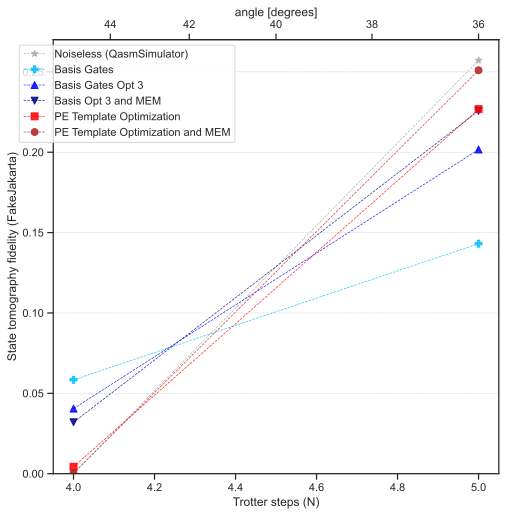

In [54]:
plot_comparisons_trotter([list_avgs_noiseless,
                          list_avgs_standard, 
                          list_avgs_standard_opt,
                          list_avgs_standard_opt_mem, 
                          list_avgs_standard_pe,
                          list_avgs_standard_pe_mem])

In [55]:
# def run_and_evaluate_with_steps_pe_mem(trotter_steps, backend, noise_level):
    
#    ########################
#     ###### Time Evolution
#     ########################

#     # The final time of the state evolution
#     target_time = np.pi

#     # Number of trotter steps
#     #trotter_steps = 8  ### CAN BE >= 4

#     # Initialize quantum circuit for 3 qubits
#     qr = QuantumRegister(7)
#     qc = QuantumCircuit(qr)

#     # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
#     qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

#     # Simulate time evolution under H_heis3 Hamiltonian
#     for _ in range(trotter_steps):
#         qc.append(return_Trott_pe(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

        
# #     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
# #     qc = qc.bind_parameters({t: target_time/trotter_steps})

#     # Generate state tomography circuits to evaluate fidelity of simulation
#     st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
#     st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)
# #    st_qcs = transpile(st_qcs, backend=backend, optimization_level=1)

#     # Display circuit for confirmation
#     # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
#     #display(st_qcs[-1].draw('latex'))  # only view trotter gates
    
#     ########################
#     ###### Execution
#     ########################
    
#     shots = 8192
#     reps = 8

#     ### Applying filter for measurement error mitigation
#     meas_filter = calculate_meas_filter(jakarta_backend)
# #    meas_filter = calculate_meas_filter_noise(sim, noise_level=noise_level)
# #     meas_filter = calculate_meas_filter_noise(sim_noisy_jakarta, noise_level=noise_level)
# # NO    meas_filter = calculate_meas_filter_noise(fake_jakarta_backend, noise_level=noise_level)
# #     meas_filter = calculate_meas_filter_noise(manila_backend, noise_level=noise_level)
    
# #     meas_filter = calculate_meas_filter_simjakarta_no_noise(sim_noisy_jakarta)
# # NO    meas_filter = calculate_meas_filter_simjakarta_no_noise(fake_jakarta_backend)
    
# #     meas_filter = calculate_meas_filter_noise_from_backend(manila_backend, noise_level=noise_level)
# #     meas_filter = calculate_meas_filter_noise_from_backend(jakarta_backend, noise_level=noise_level)


#     jobs = []
#     for _ in range(reps):
#         # execute
#         job = execute(st_qcs, backend, shots=shots)
#         print('Job ID', job.job_id())
#         jobs.append(job)
        
#     # Compute tomography fidelities for each repetition
#     fids = []
#     for job in jobs:
# #        fid = state_tomo(job.result(), st_qcs)
# #         print(job.result())
#         job_mitigated_results = meas_filter.apply(job.result())
#         fid = state_tomo(job_mitigated_results, st_qcs) ## UF
#         fids.append(fid)
        
#     #print('='*80)
#     #print('\n Steps ={:.0f}'.format(trotter_steps)) 
#     print('\n Duration ={:.0f}'.format(schedule(transpile(qc, backend),backend).duration)) 
#     print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
#     print('='*80)
    
#     return(round(np.mean(fids),4))

In [56]:
STOP

NameError: name 'STOP' is not defined

## Template Optimization and ZNE

In [85]:
#hex to bin
#https://github.com/Qiskit/qiskit-terra/blob/5be36bc58adab346edac309932125a27cbf35b78/qiskit/result/postprocess.py#L13

In [250]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2018.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""Model for schema-conformant Results."""

import copy
import warnings

from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.pulse.schedule import Schedule
from qiskit.exceptions import QiskitError
from qiskit.quantum_info.states import statevector
from qiskit.result.models import ExperimentResult
from qiskit.result import postprocess
from qiskit.result.counts import Counts
from qiskit.qobj.utils import MeasLevel
from qiskit.qobj import QobjHeader


class Result:
    """Model for Results.

    Attributes:
        backend_name (str): backend name.
        backend_version (str): backend version, in the form X.Y.Z.
        qobj_id (str): user-generated Qobj id.
        job_id (str): unique execution id from the backend.
        success (bool): True if complete input qobj executed correctly. (Implies
            each experiment success)
        results (list[ExperimentResult]): corresponding results for array of
            experiments of the input qobj
    """

    _metadata = {}

    def __init__(
        self,
        backend_name,
        backend_version,
        qobj_id,
        job_id,
        success,
        results,
        date=None,
        status=None,
        header=None,
        **kwargs,
    ):
        self._metadata = {}
        self.backend_name = backend_name
        self.backend_version = backend_version
        self.qobj_id = qobj_id
        self.job_id = job_id
        self.success = success
        self.results = results
        if date is not None:
            self.date = date
        if status is not None:
            self.status = status
        if header is not None:
            self.header = header
        self._metadata.update(kwargs)

    def __repr__(self):
        out = (
            "Result(backend_name='%s', backend_version='%s', qobj_id='%s', "
            "job_id='%s', success=%s, results=%s"
            % (
                self.backend_name,
                self.backend_version,
                self.qobj_id,
                self.job_id,
                self.success,
                self.results,
            )
        )
        if hasattr(self, "date"):
            out += ", date=%s" % self.date
        if hasattr(self, "status"):
            out += ", status=%s" % self.status
        if hasattr(self, "header"):
            out += ", status=%s" % self.header
        for key in self._metadata:
            if isinstance(self._metadata[key], str):
                value_str = "'%s'" % self._metadata[key]
            else:
                value_str = repr(self._metadata[key])
            out += f", {key}={value_str}"
        out += ")"
        return out

    def to_dict(self):
        """Return a dictionary format representation of the Result

        Returns:
            dict: The dictionary form of the Result
        """
        out_dict = {
            "backend_name": self.backend_name,
            "backend_version": self.backend_version,
            "qobj_id": self.qobj_id,
            "job_id": self.job_id,
            "success": self.success,
            "results": [x.to_dict() for x in self.results],
        }
        if hasattr(self, "date"):
            out_dict["date"] = self.date
        if hasattr(self, "status"):
            out_dict["status"] = self.status
        if hasattr(self, "header"):
            out_dict["header"] = self.header.to_dict()
        out_dict.update(self._metadata)
        return out_dict


    def __getattr__(self, name):
        try:
            return self._metadata[name]
        except KeyError as ex:
            raise AttributeError(f"Attribute {name} is not defined") from ex

    @classmethod
    def from_dict(cls, data):
        """Create a new ExperimentResultData object from a dictionary.

        Args:
            data (dict): A dictionary representing the Result to create. It
                         will be in the same format as output by
                         :meth:`to_dict`.
        Returns:
            Result: The ``Result`` object from the input dictionary.

        """

        in_data = copy.copy(data)
        in_data["results"] = [ExperimentResult.from_dict(x) for x in in_data.pop("results")]
        if "header" in in_data:
            in_data["header"] = QobjHeader.from_dict(in_data.pop("header"))
        return cls(**in_data)


    def data(self, experiment=None):
        """Get the raw data for an experiment.

        Note this data will be a single classical and quantum register and in a
        format required by the results schema. We recommend that most users use
        the get_xxx method, and the data will be post-processed for the data type.

        Args:
            experiment (str or QuantumCircuit or Schedule or int or None): the index of the
                experiment. Several types are accepted for convenience::
                * str: the name of the experiment.
                * QuantumCircuit: the name of the circuit instance will be used.
                * Schedule: the name of the schedule instance will be used.
                * int: the position of the experiment.
                * None: if there is only one experiment, returns it.

        Returns:
            dict: A dictionary of results data for an experiment. The data
            depends on the backend it ran on and the settings of `meas_level`,
            `meas_return` and `memory`.

            QASM backends return a dictionary of dictionary with the key
            'counts' and  with the counts, with the second dictionary keys
            containing a string in hex format (``0x123``) and values equal to
            the number of times this outcome was measured.

            Statevector backends return a dictionary with key 'statevector' and
            values being a list[list[complex components]] list of 2^num_qubits
            complex amplitudes. Where each complex number is represented as a 2
            entry list for each component. For example, a list of
            [0.5+1j, 0-1j] would be represented as [[0.5, 1], [0, -1]].

            Unitary backends return a dictionary with key 'unitary' and values
            being a list[list[list[complex components]]] list of
            2^num_qubits x 2^num_qubits complex amplitudes in a two entry list for
            each component. For example if the amplitude is
            [[0.5+0j, 0-1j], ...] the value returned will be
            [[[0.5, 0], [0, -1]], ...].

            The simulator backends also have an optional key 'snapshots' which
            returns a dict of snapshots specified by the simulator backend.
            The value is of the form dict[slot: dict[str: array]]
            where the keys are the requested snapshot slots, and the values are
            a dictionary of the snapshots.

        Raises:
            QiskitError: if data for the experiment could not be retrieved.
        """
        try:
            return self._get_experiment(experiment).data.to_dict()
        except (KeyError, TypeError) as ex:
            raise QiskitError(f'No data for experiment "{repr(experiment)}"') from ex



    def get_counts(self, experiment=None):
        """Get the histogram data of an experiment.

        Args:
            experiment (str or QuantumCircuit or Schedule or int or None): the index of the
                experiment, as specified by ``data([experiment])``.

        Returns:
            dict[str, int] or list[dict[str, int]]: a dictionary or a list of
            dictionaries. A dictionary has the counts for each qubit with
            the keys containing a string in binary format and separated
            according to the registers in circuit (e.g. ``0100 1110``).
            The string is little-endian (cr[0] on the right hand side).

        Raises:
            QiskitError: if there are no counts for the experiment.
        """
        if experiment is None:
            exp_keys = range(len(self.results))
        else:
            exp_keys = [experiment]

        dict_list = []
        for key in exp_keys:
            exp = self._get_experiment(key)
            try:
                header = exp.header.to_dict()
            except (AttributeError, QiskitError):  # header is not available
                header = None

            if "counts" in self.data(key).keys():
                if header:
                    counts_header = {
                        k: v
                        for k, v in header.items()
                        if k in {"time_taken", "creg_sizes", "memory_slots"}
                    }
                else:
                    counts_header = {}
                dict_list.append(Counts(self.data(key)["counts"], **counts_header))
            elif "statevector" in self.data(key).keys():
                vec = postprocess.format_statevector(self.data(key)["statevector"])
                dict_list.append(statevector.Statevector(vec).probabilities_dict(decimals=15))
            else:
                raise QiskitError(f'No counts for experiment "{repr(key)}"')

        # Return first item of dict_list if size is 1
        if len(dict_list) == 1:
            return dict_list[0]
        else:
            return dict_list



In [381]:
import pandas as pd
from qiskit.result import models
from qiskit.result import Result
from qiskit.qobj import Qobj, QobjExperimentHeader

def transform_zne_results(job_mitiq, scale_factors, folded_circuits, shots, job_id):
    '''
    Reads a job, uses zne on all statevectors, and transforms the output of mitiq 
    ZNE into a job.result to be used on state_tomo
    '''
    
    ## Add zeros to statevectors not measure to ensure zne can be calculated. Will use padas dataframe for this 
    df_ = {}
    for i in range(len(scale_factors)):
        df_[i] = pd.DataFrame.from_dict(job_mitiq.result().get_counts(i), orient='index').reset_index()
        df_[i].columns = ['sv', 'counts_'+str(i)]

    df_final = df_[0]
    for i in range(1, len(scale_factors)):
        df_final = df_final.merge(df_[i], on='sv', how='outer').replace(np.nan,0)
    df_final = df_final.set_index('sv')
    #display(df_final)
    
    all_counts =[]
    all_expectation_values = []
    for i in range(len(folded_circuits)):
        all_counts.append(df_final['counts_'+str(i)].astype(int).to_dict())
        df_final2 = round(df_final.astype(float)/shots, 4)
        all_expectation_values.append(df_final2['counts_'+str(i)].to_dict())

    ## Dictionary of expectation values, including statevectors without counts, to be passed to mitiq
    expectation_values={}
    for sv in sorted(list(df_final.index)):
        expectation_values[sv] = list(df_final2.T[sv])
        #display(expectation_values[sv])
        
    ## Run zne extrapolation for all statevectors
    mitigated_sv_counts = {}
    for sv in sorted(list(df_final.index)):

#        print("Unmitigated expectation value:", sv,round(expectation_values[sv][0],3))

        zero_noise_value = zne.ExpFactory.extrapolate(scale_factors, expectation_values[sv], asymptote=0.5)
#        print(f"Extrapolated zero-noise value:", sv, round(zero_noise_value,3))
        #zero_noise_value

        ## correcting for negative counts
        if zero_noise_value < 0:
            zero_noise_value = 0
        mitigated_sv_counts[hex(int(sv, 2))] = int(zero_noise_value*shots)
#         mitigated_sv_counts[sv] = int(zero_noise_value*shots)

    #display(mitigated_sv_counts)
    
    ## Assign mitigated statevector counts to a job.result()
    ## Based on an example from a testing file on 
    # https://github.com/Qiskit/qiskit-terra/blob/0caab4a3ec1f8ced437be59d1e77657922771392/test/python/result/test_result.py
#     raw_counts = mitigated_sv_counts
#     #print(job_mitiq.result())
#     no_header_processed_counts = {bin(int(bs[2:], 16))[2:]: counts for
#                                   (bs, counts) in raw_counts.items()}
#     data = models.ExperimentResultData(counts=raw_counts)
#     exp_result = models.ExperimentResult(shots=8192, success=True, meas_level=2, data=data)
#     result = Result(backend_name='jakarta_backend', backend_version='1.0.0',
#                     qobj_id='id-123',job_id='job-123', success=True, results=[exp_result], 
#                    )#header=QobjExperimentHeader(name="('X', 'X', 'X')" ))
#     display(result)
    
    
    raw_counts = mitigated_sv_counts
    print(raw_counts)
#     print(mock_job.result())
#         counts = result.get_counts(i)
#         new_counts = _marginalize(counts, indices)
#         new_counts_hex = {}
#         for k, v in new_counts.items():
#             new_counts_hex[_bin_to_hex(k)] = v
#         experiment_result.data.counts = new_counts_hex
        
#     mock_job
#     qiskit.result.utils
#    qheader = QobjExperimentHeader.from_dict(QobjExperimentHeader.to_dict(mock_job.result()))
       
    no_header_processed_counts = {bin(int(bs[2:], 16))[2:]: counts for
                                  (bs, counts) in raw_counts.items()}
    data = models.ExperimentResultData(counts=raw_counts)
    exp_result_header = QobjExperimentHeader(creg_sizes=[['c0', 2], ['c0', 1], ['c1', 1]],
                                     memory_slots=4, name="('X', 'X', 'X')")
    exp_result = models.ExperimentResult(shots=8192, success=True, meas_level=2, data=data, 
                                         header=exp_result_header)
    result = Result(results=[exp_result], backend_name='jakarta_backend', backend_version='nnn',
                    qobj_id="job000",job_id=job_id, success=True)
    #mock_job.result.results = mitigated_sv_counts
    display(result)
    
    return result

In [382]:
def run_and_evaluate_with_steps_pe_2_zne(trotter_steps, backend, USE_REAL_HARDWARE=False):
    ########################
    ###### Time Evolution
    ########################

    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])

    # # Simulate time evolution under H_heis3 Hamiltonian
    # for _ in range(trotter_steps):
    #     qc.append(return_Trott_pe(target_time/trotter_steps), [qr[1], qr[3], qr[5]])


    #display(qc.draw())

    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    #display(transpiled_qc_rzx.draw())
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)

    #display(qc_pe.draw())

    # qr = QuantumRegister(7)
    # qc_pe2 = QuantumCircuit(qr)
    # qc_pe2.append(qc_pe)
    # display(qc_pe2.draw())
    #Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_pe, [1,3,5])
    
    st_qcs2 = transpile(st_qcs, backend, optimization_level=3)
    #display(st_qcs2[-1].draw())
    
    shots = 8192
    reps = 2
    
#    mock_job = execute(st_qcs, fake_jakarta_backend, shots=shots)
#    print(QobjExperimentHeader.to_dict(mock_job.result()))


    jobs = []
    for _ in range(reps):
        scale_factors = [1., 1.5, 2., 2.5, 3.]
        folded_circuits = [ zne.scaling.fold_gates_at_random(st_qcs2[-1], scale) for scale in scale_factors]

#         # Check that the circuit depth is (approximately) scaled as expected
#         for j, c in enumerate(folded_circuits):
#             print(f"Number of gates of folded circuit {j} scaled by: {len(c) / len(st_qcs2[-1]):.3f}")

        if USE_REAL_HARDWARE:

            # Run the circuit on hardware
            job = execute(
                experiments=folded_circuits,
                backend=backend,
                optimization_level=0,  # Important to preserve folded gates.
                shots=shots
            )
            print('Job ID', job.job_id())
        else:
            # Simulate the circuit with noise
            noise_model = initialized_depolarizing_noise(noise_level=0.3)

            job = execute(
                experiments=folded_circuits,
                backend=Aer.get_backend("qasm_simulator"),
                noise_model=noise_model,
                basis_gates=noise_model.basis_gates,
                optimization_level=0,  # Important to preserve folded gates.
                shots=shots
            )
            print('Job ID', job.job_id())

#             print('Job ID', job.job_id())
            #print(job.result())
            
        job_mitigated_result = transform_zne_results(job, scale_factors, 
                                              folded_circuits, shots, job_id = job.job_id())
        
        jobs.append(job_mitigated_result)    
            
#     # Compute unmitigated tomography fidelities for each repetition
#     fids_unmitigated = []
#     for job in jobs:
#         fid = state_tomo(job.result(), st_qcs)
#     #         print(job.result())
#     #    job_mitigated_results = meas_filter.apply(job.result())
#     #    fid = state_tomo(job_mitigated_results, st_qcs) ## UF
#         fids_unmitigated.append(fid)
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job_mitigated_result in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
#        job_mitigated_results = meas_filter.apply(job.result())

#         print(job_mitigated_result)
#         print(st_qcs2)

        fid = state_tomo(job_mitigated_result, st_qcs2) ## UF
#        fid = state_tomo(mock_job.result(), st_qcs2) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(qc_pe, backend),backend).duration)) 
#     print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
#                                                                                    np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
 
    #round(np.mean(fids_unmitigated),4),
 
    return  round(np.mean(fids_mitigated),4)

results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'000': 939.8747437223316, '001': 1007.9251481247574, '010': 994.3549665633719, '011': 1092.6384733760933, '100': 933.4613189847815, '101': 1027.0546724855326, '110': 1050.0921810033308, '111': 1146.5984957398016}),

In [383]:
run_and_evaluate_with_steps_pe_2_zne(1, fake_jakarta_backend, USE_REAL_HARDWARE=False)

Job ID 1155a1b3-3b1e-4383-9351-572952fcab52
{'0x0': 8192}


Result(backend_name='jakarta_backend', backend_version='nnn', qobj_id='job000', job_id='1155a1b3-3b1e-4383-9351-572952fcab52', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 8192}), header=QobjExperimentHeader(creg_sizes=[['c0', 2], ['c0', 1], ['c1', 1]], memory_slots=4, name="('X', 'X', 'X')"))])

Job ID aebd3c48-b3d6-4224-a920-5376bdc52063
{'0x0': 8192}


Result(backend_name='jakarta_backend', backend_version='nnn', qobj_id='job000', job_id='aebd3c48-b3d6-4224-a920-5376bdc52063', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 8192}), header=QobjExperimentHeader(creg_sizes=[['c0', 2], ['c0', 1], ['c1', 1]], memory_slots=4, name="('X', 'X', 'X')"))])

QiskitError: "Result for ('X', 'X', 'Y') not found"

We will evaluate the noise pattern between 0.05 and 0.2.

In [ ]:
# ## 
# list_noise_vals = np.linspace(0.05, 0.2, 31)

# max_avg = 0
# list_avgs_pe_mem_noise = []
# for n in list_noise_vals:
 
#     print('='*80)
#     print('\n Noise ={:.3f} \n'.format(n))
#     print('\n Template Optimization - Optimization Level 3 - Noise Level')
#     avg = run_and_evaluate_with_steps_pe_mem(4, fake_jakarta_backend, n)
#     list_avgs_pe_mem_noise.append(avg)
#     if avg > max_avg:
#         noise_level = n
#         print('\n Noise_level for max avg = {:.4f}, {:.4f}'.format(n, avg))
#     max_avg = max(list_avgs_pe_mem_noise)
        
# ## print max a_vg and the corresponding noise level
# print(max(list_avgs_pe_mem_noise), noise_level)    

# ## plot results
# fig, ax = plt.subplots(figsize=(6,6))
# plt.scatter(list_noise_vals, list_avgs_pe_mem_noise) 
# plt.xlabel('Noise Level')
# plt.ylabel('State Fidelity')

For `Fake Jakarta`, the best run would be given by the number of Trotter steps $N_{\text{T}} = 4$ and the noise_level given by `max(list_avgs_pe_mem_noise)`.

In [ ]:
#run_and_evaluate_with_steps_pe_mem(4, fake_jakarta_backend, noise_level=noise_level)

# VI. Jakarta Runs

Goal: run $n=8, 10, 11$ Trotter steps with MEM on actual quantum device

We have separate runs for the Trotter calculation and for the measurement error mitigation.

Reading runs from Jakarta

## Standard  gates - Optimization Level 3 with Measurement Error Mitigation

### Qiskit's Error Mitigation

In [ ]:
## complete_meas_cal from job on device
meas_filter = calculate_meas_filter(jakarta_backend, running_on_device = False)

In [ ]:
def run_and_evaluate_with_steps_opt_mem_jakarta(trotter_steps, backend, meas_filter = meas_filter, 
                                               read_or_run = 'read', list_jobs=None):
    '''
    This function reads jobs already on device or runs new ones using the same approach as   
    `run_and_evaluate_with_steps_opt_mem` from section 3.5
    
    Usage: run_and_evaluate_with_steps_opt_mem_device(trotter_steps, backend, meas_filter = meas_filter, 
                                                        read_or_run = 'read', list_jobs=None)
                                               
    trotter_steps: number of Trotter steps 
    backend: device or simulation backend.
    meas_filter: meas_filter calculated on backend
    read_or_run: 'read' to read finished jobs or 'run'to run new ones. Default is 'read'
    list_jobs: list of jobs already executed on device. Default is None
    
    Returns: Mean fidelity of statevector compared to target_state
    '''
            

   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)
#    st_qcs = transpile(st_qcs, backend=backend, optimization_level=1)

    # Display circuit for confirmation
    # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates

    if read_or_run == 'run': 
    
        ########################
        ###### Execution
        ########################
        
        shots = 8192
        reps = 8

        jobs = []
        for _ in range(reps):
            # execute
            job = execute(st_qcs, backend, shots=shots)
            print('Job ID', job.job_id())
    

    elif read_or_run == 'read':
        ########################
        ###### READ
        ########################
        
        if list_jobs == None:
            print("Provide list_jobs")
        else:
            jobs = []
            for j in list_jobs:
                # retrieve
                job = backend.retrieve_job(j)
                print('Job ID', job.job_id())
                jobs.append(job)
        

    else:
        print('Define `read_or_run`')
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids.append(fid)
    
    print('='*50)    
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f} \n'.format(np.mean(fids), np.std(fids)))
    print('='*50)
    
    return(round(np.mean(fids),4))

Actual run of the Trotter circuit on the Jakarta device.

In [ ]:
# from opt-mem nb
list_jobs_n8_run4 = ['62473687b3213d24e5c05a9e', 
                     '62473689b3213d153ec05a9f',
                     '6247368b1a95e0f94a5cd571',
                     '6247368db3213da161c05aa0',
                     '6247368eb3213d4496c05aa1',
                     '6247369099622559498bad70',
                     '62473692e978c7a07afb1860',
                     '62473693b3213da123c05aa2']  ## Trotter n=8  

In [ ]:
run_and_evaluate_with_steps_opt_mem_jakarta(8, jakarta_backend, meas_filter, read_or_run='read', 
                                           list_jobs=list_jobs_n8_run4)

## Pulse Efficient Template Optimization

### Qiskit's Error Mitigation

In [ ]:
def run_and_evaluate_with_steps_pe_mem_jakarta(trotter_steps, backend, meas_filter = meas_filter, 
                                               read_or_run = 'read', list_jobs=None):
    '''
    This function reads jobs already on device or runs new ones using the same approach as   
    `run_and_evaluate_with_steps_opt_mem` from section 3.5
    
    Usage: run_and_evaluate_with_steps_opt_mem_device(trotter_steps, backend, meas_filter = meas_filter, 
                                                        read_or_run = 'read', list_jobs=None)
                                               
    trotter_steps: number of Trotter steps 
    backend: device or simulation backend.
    meas_filter: meas_filter calculated on backend
    read_or_run: 'read' to read finished jobs or 'run'to run new ones. Default is 'read'
    list_jobs: list of jobs already executed on device. Default is None
    
    Returns: Mean fidelity of statevector compared to target_state
    '''
    
   ########################
    ###### Time Evolution
    ########################
    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])


    #display(qc.draw())
    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    #display(transpiled_qc_rzx.draw())
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)

    #Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

    if read_or_run == 'run': 
        ########################
        ###### Execution
        ########################

        shots = 8192
        reps = 8


        jobs = []
        for _ in range(reps):
            # execute
            job = execute(st_qcs, backend, shots=shots)
            print('Job ID', job.job_id())
            jobs.append(job)
            
    elif read_or_run == 'read':
        ########################
        ###### READ
        ########################
        
        if list_jobs == None:
            print("Provide list_jobs")
        else:
            jobs = []
            for j in list_jobs:
                # retrieve
                job = backend.retrieve_job(j)
                print('Job ID', job.job_id())
                jobs.append(job)
        

    else:
        print('Define `read_or_run`')
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids.append(fid)
        
    print('='*50)    
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f} \n'.format(np.mean(fids), np.std(fids)))
    print('='*50)
    
    return(round(np.mean(fids),4))

$N=8$

In [ ]:
list_jobs_pe_n8_run1 = ['625b5ae0f1fb8d40af3ad927',
                        '625b5ae4e1f245f2cdeb6ce4',
                        '625b5ae90d8f19451bac1aaa',
                        '625b5aed9e311582cf838b50',
                        '625b5af13bbc9fb061735c4e',
                        '625b5af5736894b9c6c8bce7',
                        '625b5af98e4b23cb72d30a36',
                        '625b5afda7e9666acddee870']

run_and_evaluate_with_steps_pe_mem_jakarta(8, jakarta_backend, meas_filter, read_or_run='read', 
                                           list_jobs=list_jobs_pe_n8_run1)

$N=11$

In [ ]:
list_jobs_pe_n11_run1 = ['625b5cc473689461f9c8bced',
                        '625b5cca8e4b231934d30a38',
                        '625b5cce35e1ec41d9253740',
                        '625b5cd3f1fb8d67323ad92d',
                        '625b5cd87368941e87c8bcee',
                        '625b5cdda7e96664addee873',
                        '625b5ce20d8f1980abac1aaf',
                        '625b5ce7e3b67fc84a3abd81']

run_and_evaluate_with_steps_pe_mem_jakarta(11, jakarta_backend, meas_filter, read_or_run='read', 
                                           list_jobs=list_jobs_pe_n11_run1)

In [385]:
### ZNE

In [386]:
### ZNE list of jobs
# list_jobs_pe__zne_n8_run2 = ['625b638de1f2454bfaeb6cf8',
#                             '625b638fe1f245144ceb6cf9',
#                             '625b6392e3b67f21b63abd90',
#                             '625b63949e31154ea4838b5c',
#                             '625b6396e1f245f0a4eb6cfa',
#                             '625b6398a7e9669575dee87c',
#                             '625b639a3bbc9f3d66735c5f',
#                             '625b639fe3b67fa15a3abd91']

# list_jobs_pe__zne_n11_run1 = ['625b657ee1f24566fceb6d02',
#                             '625b65819e31158629838b5f',
#                             '625b6584a7e9667c67dee880',
#                             '625b65873bbc9f290e735c62',
#                             '625b6589e3b67f59143abd94',
#                             '625b658ce1f2457306eb6d03',
#                             '625b658e9e311592e4838b61',
#                             '625b659135e1ecbe6f253753'
#                              ]

# #What about '625b5d9ea7e9668cb6dee876'

# VII. Other backends

To confirm the device independence of our results, we will run the same experiments as above using `ibmq_manila`. This device has only 5 qubits, but since our experiments are only using 3 sequentially connected qubits, we will use manila's $q_1, q_2,$ and $q_3$ for our experiments. 

In [ ]:
provider = IBMQ.load_account()
manila_backend = provider.backend.ibmq_manila

try:
    # Check if backend supports Pulse
    backend_config = test_backend.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")

Unfortunately, because `ibmq_manila` does not suppurt Pulse, we are not able to test the pulse efficient template optimization approach on this device. We can, however, run the experiments with error mitigation and the default qiskit gates to confirm we obtain similar results.

## Standard  gates - Optimization Level 3 with Measurement Error Mitigation

### Qiskit's Error Mitigation

In [ ]:
meas_filter_manila = calculate_meas_filter(manila_backend, running_on_device = False, 
                                           job_id='625e7e76d0d73f2294bae23f')

In [ ]:
def run_and_evaluate_with_steps_opt_mem_manila(trotter_steps, backend, meas_filter = meas_filter, 
                                               read_or_run = 'read', list_jobs=None):
    '''
    This function reads jobs already on device or runs new ones using the same approach as   
    `run_and_evaluate_with_steps_opt_mem` from section 3.5
    
    Usage: run_and_evaluate_with_steps_opt_mem_device(trotter_steps, backend, meas_filter = meas_filter, 
                                                        read_or_run = 'read', list_jobs=None)
                                               
    trotter_steps: number of Trotter steps 
    backend: device or simulation backend.
    meas_filter: meas_filter calculated on backend
    read_or_run: 'read' to read finished jobs or 'run'to run new ones. Default is 'read'
    list_jobs: list of jobs already executed on device. Default is None
    
    Returns: Mean fidelity of statevector compared to target_state
    '''
            

   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(5)
    qc = QuantumCircuit(qr)
    
    ##### We will use qubits 1,2, and 3 on Manila because of thesimilar coupling map to 1, 3, and 5 on Jakarta

    # Prepare initial state (remember we are only evolving 3 of the 5 qubits on manila qubits (q_3, q_2, q_1) 
    # corresponding to the state |110>)
    qc.x([2,3])  # DO NOT MODIFY (|q_3,q_2,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[2], qr[3]]) ## Using 1,2,3 on Manila

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[2], qr[3]])
    st_qcs = transpile(st_qcs, backend, optimization_level=3)
#    st_qcs = transpile(st_qcs, backend=backend, optimization_level=1)

    # Display circuit for confirmation
    # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates

    if read_or_run == 'run': 
    
        ########################
        ###### Execution
        ########################
        
        shots = 8192
        reps = 5 ## Limited to 5 by the device backend

        jobs = []
        for _ in range(reps):
            # execute
            job = execute(st_qcs, backend, shots=shots)
            print('Job ID', job.job_id())
    

    elif read_or_run == 'read':
        ########################
        ###### READ
        ########################
        
        if list_jobs == None:
            print("Provide list_jobs")
        else:
            jobs = []
            for j in list_jobs:
                # retrieve
                job = backend.retrieve_job(j)
                print('Job ID', job.job_id())
                jobs.append(job)
        

    else:
        print('Define `read_or_run`')
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) 
        fids.append(fid)
    
    print('='*50)    
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f} \n'.format(np.mean(fids), np.std(fids)))
    print('='*50)
    
    return(round(np.mean(fids),4))

In [ ]:
list_jobs_n8_manila =['625e802bd7fceaee9d87c968',
                      '625e802cdf21bf5a1147ce53',
                      '625e802ed7fcea43f087c969',
                      '625e803019e67061d11f7a0c',
                      '625e80315ce57bfd51beaf50']

In [ ]:
run_and_evaluate_with_steps_opt_mem_manila(8, manila_backend, meas_filter_manila, read_or_run='read',
                                          list_jobs=list_jobs_n8_manila)

As we would have expected, the results from `ibmq_manila` are similar to the ones obtained on `ibmq_jakarta`.

# VIII. References

[[1]](https://arxiv.org/abs/2105.01063) Earnest, N., C. Tornow, and D. J. Egger (2021), Physical Review Research 3 (4), 10.1103/physrevresearch.3.043088.

[[2]](https://www.science.org/doi/10.1126/science.273.5278.1073) Lloyd, S. (1996), Science 273 (5278), 1073.

[[3]](https://arxiv.org/abs/1311.7626) Heras, U. L. _et al._ (2014), Physical Review Letters 112 (20),
10.1103/physrevlett.112.200501.

[[4]](https://arxiv.org/abs/1907.03505) Tacchino, F., A. Chiesa, S. Carretta, and D. Gerace (2019),
Advanced Quantum Technologies 3 (3), 1900052.

[[]](https://arxiv.org/abs/1502.06778) Salathé, Y. _et al._ (2015), Phys. Rev. X 5, 021027.

[[]](https://arxiv.org/abs/1906.06343) Smith, A., M. S. Kim, F. Pollmann, and J. Knolle (2019), npj Quantum Information 5 (1), 10.1038/s41534-019-0217-0.



In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table